In [ ]:
# 모델 저장 문제, EarlyStopping 적용 문제

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import autokeras as ak

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder    # 문자열, NaN -> 수치화
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:
    # rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/house_price_auto' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

# ---------------------------------------------------------------------

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Using TensorFlow backend


In [ ]:
df = pd.read_csv('./train.csv')
print(type(df))
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
(1460, 81)


In [ ]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
cols = df.columns.values
print(cols)

['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleTy

In [ ]:
df.info() # object: 문자열
# Id  1460 non-null   int64: 8바이트 정수형 1460개 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# df['PoolQC']

In [ ]:
# df.isnull().sum()

In [ ]:
print(df.head(1)) # 문자를 숫자형으로 변경해야 학습 가능

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        

In [ ]:
print(df['Id'].dtype)
print(df['MSZoning'].dtype) # 문자열

int64
object


In [ ]:
# 데이터 전처리, 문자열 -> 정수로 변경
# encoder = LabelEncoder()
# for col in cols:
#     if (df[col].dtype == 'object'): # 컬럼의 타입이 object인 컬럼 산출
#         # print('object')
#         df[col] = encoder.fit_transform(df[col]) # 0 ~ 고유한 정수로 변경

In [ ]:
# df.info()

In [ ]:
# df['PoolQC']

In [ ]:
# df.head(5)

In [ ]:
# df.isnull().sum() # 컬럼별 결측치, 결측치도 숫자로 변경됨.

In [ ]:
# df['Alley'].isnull().sum() # 'Alley(골목)' 컬럼 결측치, 결측치도 숫자로 변경됨.

In [ ]:
# df.info()

In [ ]:
# df.fillna(0, inplace=True)

In [ ]:
# df.info()

In [ ]:
# 상관 분석, 상관이 강할수록 정확도가 높고 학습이 잘됨.
# 예) 집값이 높아지면 컴퓨터 속도가 빨라짐? 상관성이 없음으로 학습이 안됨

# X측: LotFrontage, Y측: LotFrontage -> 1, 강한상관 자기 자신
# X측: LotFrontage, Y측: SalePrice -> 0.351799, 양의 상관,
# LotFrontage(집 앞 마당): 마당(X 축)이 넓어지면 집 가격(Y 축)은 상승한다.
# X측: LotShape, Y측: SalePrice -> -0.255580, 음의 상관,
# LotShape(대지의 모양): 부지의 모양이 너무 각이 많아지면 집값이 떨어짐.

# df_corr = df.corr()
# df_corr

In [ ]:
# df_corr.sort_values('SalePrice', ascending=False, inplace=True) # SalePrice 컬럼 기준 내림차순 정렬
# df_corr['SalePrice'].head(10) # 상관계수가 가장높은 컬럼 10개 출력

In [ ]:
# print(type(df_corr['SalePrice'].head(10))) # 하나의 컬럼, 1차원과 비슷
# print(df_corr['SalePrice'].head(10).index) # 상관 관계에서 컬럼명이 index

In [ ]:
# cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
#        'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']
# sb.pairplot(df[cols])
# plt.show()

In [ ]:
Y = df.pop('SalePrice')
print(Y.shape)

(1460,)


In [ ]:
Y.head(3)

0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64

In [ ]:
X = df
print(X.shape)
print(X.head(1))

(1460, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    G

In [ ]:
# 예측을 위한 회귀모델링은 표준화 생략 가능.
# scaler = StandardScaler()
# X = scaler.fit_transform(df)
# print(X[:3])
# X=df

In [ ]:
# 데이터 분할, 훈련+검증: 90%(훈련: 80%, 검증: 20%), 테스트: 5%
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle=True, random_state=0)
print(x_train.shape) # 훈련+검증: 1314 건, 독립변수 9개
print(y_train.shape) # 훈련+검증: 1314 건, Target(종속변수) 1개, SalePrice
print(x_test.shape)  # 테스트: 146 건, 독립변수 9개
print(y_test.shape)  # 테스트: 146 건, Target(종속변수) 1개, SalePrice

(1387, 80)
(1387,)
(73, 80)
(73,)


In [ ]:
print(type(x_train))
print(x_train.head(1))

<class 'pandas.core.frame.DataFrame'>
      Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
688  689          20       RL         60.0     8089   Pave   NaN      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
688         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
688       Norm     1Fam     1Story            8            6       2007   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
688          2007     Gable  CompShg     MetalSd     MetalSd    BrkFace   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
688         0.0        Gd        TA      PConc       Gd       TA           Av   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
688          GLQ         945          Unf           0        474         1419   

    Heating HeatingQC CentralAir

In [ ]:
print(y_train.head(1))

688    392000
Name: SalePrice, dtype: int64


In [ ]:
# Tensowflow
# 모델 설계, Node, Epochs, batch_size
# SEED = 0
# os.environ['PYTHONHASHSEED'] = str(SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

# tf.random.set_seed(SEED) # Global seed
# np.random.seed(SEED)
# random.seed(SEED)

# model = Sequential()
# model.add(Dense(30, input_dim=8, activation='linear', name='layer1'))
# model.add(Dense(20, activation='linear', name='layer2'))
# model.add(Dense(1, activation='linear', name='layer5'))
# model.compile(optimizer=Adam(lr=0.001), loss='mse')
# model.summary()

# patience=7: 손실이 7번 늘어날때까지 훈련을 계속, 7번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
# es = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

# hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,
#                  epochs=1000, batch_size=10, callbacks=[es])

In [ ]:
print(type(x_train))
print(type(y_train))
print(type(x_train.to_numpy()))
print(type(y_train.to_numpy()))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Autokeras
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

# AutoKeras를 사용하여 구조화된 데이터에 대한 회귀 모델을 생성합니다.
# 사용할 옵티마이저 정의 (Adam 옵티마이저, 학습률=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # 기본값 Adam, 0.001
akmodel = ak.StructuredDataRegressor(
    optimizer=optimizer,
    max_trials=1,  # 최대 시도 횟수를 1로 설정합니다. 이는 AutoKeras가 탐색할 모델 구성의 최대 개수입니다.
    overwrite=True,  # 이전에 실행한 모델 훈련 세션을 덮어쓸지 여부를 결정합니다. True이면 이전 세션을 덮어씁니다.
    metrics=['mse']  # 모델 평가 기준으로 평균 제곱 오차(Mean Squared Error, MSE)를 사용합니다.
)

import os, datetime
# 로그 디렉토리 생성: 현재 시간을 기반으로한 포맷으로 생성됨
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# TensorBoard 콜백 정의:
# - logdir: TensorBoard가 생성된 로그 파일을 저장할 디렉토리 경로
# - histogram_freq=0: 히스토그램 시각화를 얼마나 자주 기록할지를 설정합니다.
#   여기서는 0으로 설정하여 히스토그램을 기록하지 않음을 의미합니다. Autokeras는 0을 지정해야함.
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)

# patience=7: 손실이 7번 늘어날때까지 훈련을 계속, 7번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
es = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# 모델을 훈련합니다. x_train은 입력 데이터, y_train은 타겟 데이터입니다.
#     batch_size=10,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
#     validation_split=0.2,  # 전체 훈련 데이터의 20%를 검증 데이터로 사용
akmodel.fit(
    x_train.to_numpy(),
    y_train.to_numpy(),
    validation_split=0.2,  # 전체 훈련 데이터의 20%를 검증 데이터로 사용합니다. 이는 모델의 성능을 검증하기 위해 사용됩니다.
    epochs=10,  # 전체 훈련 데이터셋에 대해 모델을 5번 반복 훈련합니다. 기본 1000
    batch_size=32,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
    callbacks=[tensorboard_callback, es])

Trial 1 Complete [00h 00m 16s]
val_loss: 2281485056.0

Best val_loss So Far: 2281485056.0
Total elapsed time: 00h 00m 16s
Epoch 1/10
44/44 [==============================] - 2s 5ms/step - loss: 38758014976.0000
Epoch 2/10
44/44 [==============================] - 0s 4ms/step - loss: 37238157312.0000
Epoch 3/10
44/44 [==============================] - 0s 4ms/step - loss: 29789640704.0000
Epoch 4/10
44/44 [==============================] - 0s 3ms/step - loss: 16127285248.0000
Epoch 5/10
44/44 [==============================] - 0s 3ms/step - loss: 8136574976.0000
Epoch 6/10
44/44 [==============================] - 0s 4ms/step - loss: 5892165632.0000
Epoch 7/10
44/44 [==============================] - 0s 4ms/step - loss: 4538786816.0000
Epoch 8/10
44/44 [==============================] - 0s 4ms/step - loss: 3804356608.0000
Epoch 9/10
44/44 [==============================] - 0s 3ms/step - loss: 3374816256.0000
Epoch 10/10
44/44 [==============================] - 0s 3ms/step - loss: 306823321

In [ ]:
# Tensorboard
# %load_ext tensorboard
%reload_ext tensorboard
# %tensorboard --logdir logs
%tensorboard --logdir logs  --host localhost

Reusing TensorBoard on port 6006 (pid 18112), started 2 days, 20:12:13 ago. (Use '!kill 18112' to kill it.)

In [ ]:
# # 시각화
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, loss_ax = plt.subplots()
# # plt.figure(figsize=(6,4)) # ERROR
# fig.set_size_inches(10, 5)  # 챠트 크기 설정

# # 왼쪽 y 축 설정
# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 지원 안됨
# loss_ax.set_ylim([0.0, 3613289216.0000]) # 값을 반영하여 변경 ★

# # 축 레이블 설정
# loss_ax.set_xlabel('epoch')  # 학습 횟수
# loss_ax.set_ylabel('loss')   # 오차

# loss_ax.legend(loc='upper left') # 오차 레이블 위치

# plt.show()
# # train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# # val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.


In [ ]:
akmodel.evaluate(x_test, y_test)

3/3 [==============================] - 1s 4ms/step - loss: 5989901312.0000


5989901312.0

In [ ]:
# First we export the model to a keras model
model = akmodel.export_model()

# Now, we ask for the model Sumary:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 80)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                2592      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

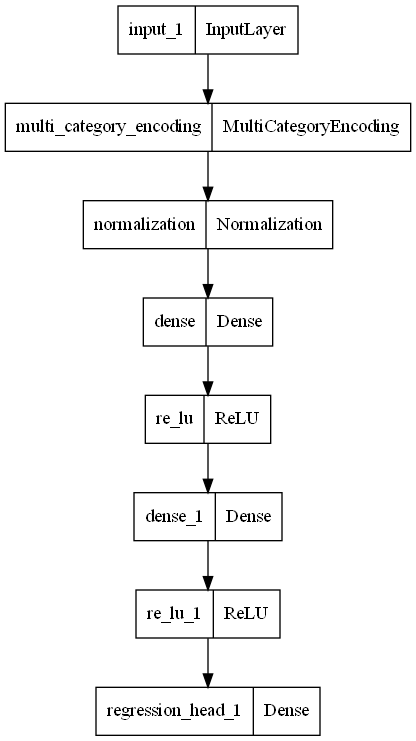

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
try:

    model.save("House_price_auto_model", save_format="tf")

except:

    model.save("House_price_auto_model.h5")

INFO:tensorflow:Assets written to: House_price_auto_model\assets


In [ ]:
# model.save('./house_price.h5')  # X
# model.save('./house_price.h5', save_format="tf")  # X
model.save("House_price_auto_model", save_format="tf")

INFO:tensorflow:Assets written to: House_price_auto_model\assets


In [ ]:
# model = load_model('./house_price.h5')
from tensorflow.keras.models import load_model
model = load_model("House_price_auto_model", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
# cols = df.columns.values
# print(cols)

In [ ]:
# 데이터 전처리, 문자열 -> 정수로 변경
# encoder = LabelEncoder()
# for col in cols:
#     if (x_test[col].dtype == 'object'): # 컬럼의 타입이 object인 컬럼 산출
#         # print('object')
#         x_test[col] = encoder.fit_transform(x_test[col]) # 0 ~ 고유한 정수로 변경

In [ ]:
x_test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Alloca
491,492,50,RL,79.0,9490,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Artery,Norm,1Fam,1.5Fin,6,7,1941,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,CBlock,TA,TA,No,BLQ,403,Rec,165,238,806,GasA,TA,Y,FuseA,958,620,0,1578,1,0,1,0,3,1,Fa,5,Typ,2,TA,Attchd,1941.0,Unf,1,240,TA,TA,Y,0,0,32,0,0,0,NaN,MnPrv,NaN,0,8,2006,WD,Normal


In [ ]:
y_test_p = akmodel.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

3/3 [==============================] - 0s 4ms/step
<class 'numpy.ndarray'>
(73, 1)


In [ ]:
y_test_p = model.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
print(y_test[:3])
print(y_test_p[:3])

In [ ]:
cnt=50
plt.plot(range(0,cnt), y_test[:cnt], label='real value') # 실제 집값
plt.plot(range(0,cnt), y_test_p[:cnt], label='predict value') # 예측 집값
plt.legend()
plt.show()